MODEL 4 - WHAT_NEXT_PREDICTION BASED ON GENDER (MULTI-MODEL)

***

In [1]:
# load packages 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings 

# model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Dropout

# float format
pd.options.display.float_format = '{:,.2f}'.format

# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load data_cleaning dataframe

path1 = '/content/drive/MyDrive/Colab Notebooks/VVNM/data_cleaning.csv' 
#path1 = '/content/drive/MyDrive/Colab Notebooks/data_cleaning.csv'

data_cleaning = pd.read_csv(path1)
data_cleaning = data_cleaning.drop(['Unnamed: 0'],axis = 1)
data_cleaning.head(4)

,USER_KEY,USER_NAME,USER_AGE,USER_SEX,VIEW_DATE,ASSET_TYPE,ASSET_CATEGORY,SRC_GENRE_DESC,CHANNEL,ASSET_NAME,PRG_DURATION_MIN,VIEW_DURATION_MIN,VIEWERSHIP_KEY,ASSET_KEY,VIEW_RATING
0,489647,A98815,73,F,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,ΕΡΤ1,Super League SOUROTI 2018/19 (L)(PANAITOLIKOS ...,115,"17,5",8769,6548,1
1,489647,A98815,73,F,10/12/18 00:00:00,TSTV,SPORTS,SPORTS-LIVE,"Eurosport 1 (International, GREEK)",Sports show (ALL SPORTS: WATTS ),15,"12,83",8770,7633,4
2,490873,babil,30,F,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,novasports1 HD,Greek Football Championship 2018/19 (L)(PANION...,130,"23,27",8771,7634,1
3,488305,9anti1,29,M,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,novasports1 HD,Greek Football Championship 2018/19 (L)(PANION...,130,"73,95",8772,7634,3


In [4]:
# create dictionary with USER_KEY as keys and USER_NAME as values
#users_dict = pd.Series(data_cleaning.USER_NAME.values,index=data_cleaning.USER_KEY).to_dict()
#users_dict

In [5]:
# sort the data - column "VIEW_DATE"
data_cleaning.sort_values('VIEW_DATE', inplace = True)
data_cleaning.head(3)

,USER_KEY,USER_NAME,USER_AGE,USER_SEX,VIEW_DATE,ASSET_TYPE,ASSET_CATEGORY,SRC_GENRE_DESC,CHANNEL,ASSET_NAME,PRG_DURATION_MIN,VIEW_DURATION_MIN,VIEWERSHIP_KEY,ASSET_KEY,VIEW_RATING
1335051,2605247,OTT_12DS4Y0Z,94,M,01/12/18 00:00:00,VOD,MOVIES,ROMANTIC COMEDY,UNKNOWN,SNOWMANCE,"139,594","107,38",1343820,5486,4
1352122,484634,trelas4,34,F,01/12/18 00:00:00,VOD,MOVIES,"MYSTERY,THRILLER",UNKNOWN,THE LIMEHOUSE GOLEM,"61,269","47,13",1360891,5488,4
1352121,485002,GM210913,65,F,01/12/18 00:00:00,LIVE TV,SHOWS,SHOW,ΕΡΤ1,Sports - Weather(CENTRAL NEWS),65,"2,73",1360890,64,1


In [6]:
# group by USER_KEY - SRC_GENRE_DESC 
# input = data_cleaning.groupby("USER_KEY")["SRC_GENRE_DESC"].apply(list)
# print(input.shape)
# input.head(5)

# Group columns by USER_KEY

input = data_cleaning.groupby(["USER_KEY"]).apply(lambda x: [list(x['USER_SEX']),
                                                             list(x['SRC_GENRE_DESC'])]).apply(pd.Series)

input.columns = ["USER_SEX_SEQ","GENRE_SEQ"]
input.head(5)

,USER_SEX_SEQ,GENRE_SEQ
USER_KEY,,
-1,"[F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, ...","[TRUE STORY, ACTION,ADVENTURE, COMEDY, TRUE ST..."
461514,"[F, F, F, F]","[SPORTS-LIVE, SPORTS-LIVE, UNKNOWN, SPORTS-LIVE]"
461564,"[M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...","[SPORTS-LIVE, SPORTS-LIVE, SPORTS-LIVE, SPORTS..."
461573,"[M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...","[SPORTS-LIVE, SPORTS-LIVE, SPORTS-LIVE, SPORTS..."
461607,[F],"[COMEDY,FAMILY]"


In [7]:
# find unique elements of genre - sex
genres = input["GENRE_SEQ"].explode().unique()

sex = input["USER_SEX_SEQ"].explode().unique()

In [8]:
# create vocabulary - unique elements and size of unique elements 

vocab = list(genres)
vocab_size = len(vocab)

In [9]:
# genres2id - create tokens of genres 

genres2id = {i:j for j,i in enumerate(genres)}

In [10]:
# sex2id - create tokens of genders 

sex2id = {i:j for j,i in enumerate(sex)}

In [11]:
# id2genres - numbering of the genres 

id2genres = {j:i for i,j in genres2id.items()}

In [12]:
# id2sex - numbering of the sex 

id2sex = {j:i for i,j in sex2id.items()}

In [13]:
# syntax to get elements 
print(input.iloc[1][0]) # sex 
print(input.iloc[1][1]) # genres 

['F', 'F', 'F', 'F']
['SPORTS-LIVE', 'SPORTS-LIVE', 'UNKNOWN', 'SPORTS-LIVE']


In [14]:
# create sequence_data - for both columns genre sequences and sex respectively

sequence_data_genres = []
sequence_data_sex = []

for i in range(0,len(input)):
  if len(input.iloc[i][1]) >= 6:
    sequence_data_genres.append(list(map(genres2id.get, input.iloc[i][1])))
    sequence_data_sex.append(list(map(sex2id.get, input.iloc[i][0])))

In [15]:
# check for equal lengths 
print(len(sequence_data_genres))
print(len(sequence_data_sex))

62619
62619


In [16]:
# To be used for all elements of each user 

from more_itertools import windowed

window_size = 5 

sequences = []
next_view = []
sex_input = []
 
for j in range(0,len(sequence_data_genres)):
  
  for i in windowed(sequence_data_genres[j], window_size+1):
    sequences.append(i[:-1])
    next_view.append(i[-1])
    
  # we use the windowed method into the sex_input too 
  for k in windowed(sequence_data_sex[j], window_size+1):
    sex_input.append(k[-1])

In [17]:
sequence_data_genres[3:5]

[[39, 39, 37, 29, 39, 29, 37, 29, 29, 37, 39, 29],
 [29, 29, 39, 29, 29, 29, 39]]

In [18]:
sequence_data_sex[3:5]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1]]

In [19]:
sex_input[3:5]

[0, 0]

In [20]:
# Check the above results  
print(len(sequences))
print(len(next_view))
print(len(sex_input))

1282013
1282013
1282013


In [21]:
# create X and Y 

X_seq = []
X_sex = []
Y = []

for i in range(0,len(sequences)):
  # sequences of fixed length vectors
  X_seq.append(sequences[i])
  # target variable - next sequence 
  Y.append((next_view[i]))
  # categorical variable male or female 
  if sex_input[i] == 0 :
    X_sex.append([1,0])
  else:
    X_sex.append([0,1])    

In [22]:
print(X_seq[1]) # genres sequences 
print(X_sex[1]) # sex indication

(1, 2, 0, 3, 4)
[1, 0]


In [23]:
print(Y[1])

2


In [24]:
# convert to arrays X1, Y1
X1_seq = np.array(X_seq)
X1_sex = np.array(X_sex)
Y1 = np.array(Y)

In [25]:
Y1 = to_categorical(Y1, num_classes = vocab_size)

In [26]:
print(X1_seq.shape)
print(X1_sex.shape)
print(Y1.shape)

(1282013, 5)
(1282013, 2)
(1282013, 65)


In [27]:
# X1_seq split into rest and test datasets - 

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X1_seq, Y1)

print(sss)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, test_index in sss.split(X1_seq, Y1):
     print("REST:", train_index, "TEST:", test_index)
     X_seq_rest, X_seq_test = X1_seq[train_index], X1_seq[test_index]
     Y_rest, Y_test = Y1[train_index], Y1[test_index]

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("Shape of X_seq_test:", X_seq_test.shape)
print("Shape of Y_test:", Y_test.shape)

print("Shape of X_seq_rest:", X_seq_rest.shape)
print("Shape of Y_rest:", Y_rest.shape)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
REST: [331718 172903  62391 ... 452051 492295 945968] TEST: [977931 412640 648170 ... 615593 135790 221107]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of X_seq_test: (256403, 5)
Shape of Y_test: (256403, 65)
Shape of X_seq_rest: (1025610, 5)
Shape of Y_rest: (1025610, 65)


In [28]:
# split into train and validation datasets 

from sklearn.model_selection import StratifiedShuffleSplit

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss1.get_n_splits(X_seq_rest, Y_rest)

print(sss1)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, val_index in sss1.split(X_seq_rest, Y_rest):
     print("TRAIN:", train_index, "VAL:", val_index)
     X_seq_train, X_seq_val = X_seq_rest[train_index], X_seq_rest[val_index]
     Y_train, Y_val = Y_rest[train_index], Y_rest[val_index]

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("Shape of X_seq_val:", X_seq_val.shape)
print("Shape of Y_val:", Y_val.shape)

print("Shape of X_seq_train:", X_seq_train.shape)
print("Shape of Y_train:", Y_train.shape)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)
TRAIN: [ 209031  126711    6259 ... 1020490  894168  414652] VAL: [553919 911660 969865 ... 891441 798914 598041]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of X_seq_val: (256403, 5)
Shape of Y_val: (256403, 65)
Shape of X_seq_train: (769207, 5)
Shape of Y_train: (769207, 65)


In [29]:
# X1_sex split into train and test datasets - 

from sklearn.model_selection import StratifiedShuffleSplit

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss2.get_n_splits(X1_sex, Y1)

print(sss2)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, test_index in sss2.split(X1_sex, Y1):
     print("REST:", train_index, "TEST:", test_index)
     X_sex_rest, X_sex_test = X1_sex[train_index], X1_sex[test_index]
     Y_rest, Y_test = Y1[train_index], Y1[test_index]

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("Shape of X_sex_test:", X_sex_test.shape)
print("Shape of Y_test:", Y_test.shape)

print("Shape of X_sex_rest:", X_sex_rest.shape)
print("Shape of Y_rest:", Y_rest.shape)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
REST: [331718 172903  62391 ... 452051 492295 945968] TEST: [977931 412640 648170 ... 615593 135790 221107]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of X_sex_test: (256403, 2)
Shape of Y_test: (256403, 65)
Shape of X_sex_rest: (1025610, 2)
Shape of Y_rest: (1025610, 65)


In [30]:
# split into train and validation datasets 

from sklearn.model_selection import StratifiedShuffleSplit

sss3 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss3.get_n_splits(X_sex_rest, Y_rest)

print(sss3)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, val_index in sss3.split(X_sex_rest, Y_rest):
     print("TRAIN:", train_index, "VAL:", val_index)
     X_sex_train, X_sex_val = X_sex_rest[train_index], X_sex_rest[val_index]
     Y_train, Y_val = Y_rest[train_index], Y_rest[val_index]

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("Shape of X_sex_val:", X_sex_val.shape)
print("Shape of Y_val:", Y_val.shape)

print("Shape of X_sex_train:", X_sex_train.shape)
print("Shape of Y_train:", Y_train.shape)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)
TRAIN: [ 209031  126711    6259 ... 1020490  894168  414652] VAL: [553919 911660 969865 ... 891441 798914 598041]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of X_sex_val: (256403, 2)
Shape of Y_val: (256403, 65)
Shape of X_sex_train: (769207, 2)
Shape of Y_train: (769207, 65)


In [31]:
print(len(X_sex_test))
print(len(X_seq_test))
print(len(Y_test))
print("~~~~~~~~~~~~~~~~~")
print(len(X_sex_train))
print(len(X_seq_train))
print(len(Y_train))
print("~~~~~~~~~~~~~~~~~")
print(len(X_sex_val))
print(len(X_seq_val))
print(len(Y_val))

256403
256403
256403
~~~~~~~~~~~~~~~~~
769207
769207
769207
~~~~~~~~~~~~~~~~~
256403
256403
256403


In [32]:
print(X1_seq[2].shape)
print("~~~~~~~~~~~~~~~~~")
print(X1_sex[1].shape)
print("~~~~~~~~~~~~~~~~~")
print(Y1.shape)

(5,)
~~~~~~~~~~~~~~~~~
(2,)
~~~~~~~~~~~~~~~~~
(1282013, 65)


In [33]:
# Use Input layers, specify input shape (dimensions except first) - 769207 is the train dataset length 

inp_emb_data = keras.layers.Input(shape = X1_seq[1].shape)

inp_gender_data = keras.layers.Input(shape= X1_sex[1].shape)

In [34]:
# embedding layer 

emb = keras.layers.Embedding(input_dim = vocab_size, output_dim = 50)(inp_emb_data)

In [35]:
# flatten the embedding output 
flatten = keras.layers.Flatten()(emb)

In [36]:
# Concatenate two layers

conc = keras.layers.Concatenate()([flatten, inp_gender_data])
dense1 = keras.layers.Dense(256, activation=tf.nn.relu, )(conc)

In [37]:
# dropout layer
dropout1 = tf.keras.layers.Dropout(0.3)(dense1)

In [38]:
# Creating output layer
out = keras.layers.Dense(vocab_size, activation= "softmax")(dropout1)

In [39]:
model = keras.Model(inputs=[inp_emb_data, inp_gender_data], outputs=out)

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 50)        3250        input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 250)          0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

In [41]:
# Define metrics

metrics = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5_categorical_accuracy", dtype=None)

metrics1 = tf.keras.metrics.AUC(curve="ROC")

In [42]:
# Compile the model 

model.compile(loss="categorical_crossentropy", 
              optimizer = Adam(learning_rate=0.002),
              metrics = ['accuracy', metrics, metrics1])

In [43]:
# Define callbacks

callback  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

# Define checkpoint callback
filepath_1 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model4/checkpoint_model4.h5'
checkpoint = ModelCheckpoint(filepath_1, monitor='val_loss', verbose=1, save_best_only=True)

In [44]:
# fit the model 

model_fit = model.fit( [X_seq_train, X_sex_train], Y_train, 
                      epochs = 100,
                      batch_size = 256,
                      validation_data = ([X_seq_val, X_sex_val], Y_val),
                      callbacks=[callback, checkpoint])

Epoch 1/100
3005/3005 [==============================] - 28s 8ms/step - loss: 2.4285 - accuracy: 0.4019 - top_5_categorical_accuracy: 0.6769 - auc: 0.9058 - val_loss: 2.3724 - val_accuracy: 0.4055 - val_top_5_categorical_accuracy: 0.6916 - val_auc: 0.9119

Epoch 00001: val_loss improved from inf to 2.37244, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model4/checkpoint_model4.h5
Epoch 2/100
3005/3005 [==============================] - 23s 8ms/step - loss: 2.3827 - accuracy: 0.4068 - top_5_categorical_accuracy: 0.6885 - auc: 0.9095 - val_loss: 2.3663 - val_accuracy: 0.4067 - val_top_5_categorical_accuracy: 0.6931 - val_auc: 0.9110

Epoch 00002: val_loss improved from 2.37244 to 2.36631, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model4/checkpoint_model4.h5
Epoch 3/100
3005/3005 [==============================] - 23s 8ms/step - loss: 2.3762 - accuracy: 0.4077 - top_5_categorical_accuracy: 0.6906 - auc: 0.9101 - val_loss: 2.3651 - 

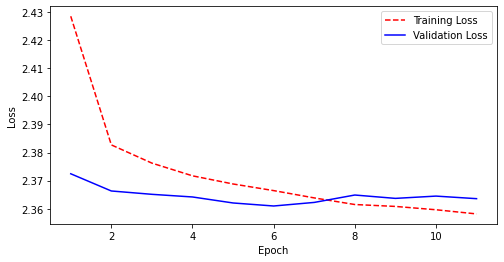

In [45]:
# Get training and test loss histories
training_loss = model_fit.history['loss']
validation_loss = model_fit.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [46]:
# Save model and architecture to single file
filepath_2 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model4/Saved_fmodel4.h5' 
model.save(filepath_2, overwrite= True)

#Load the model
#loaded_model = load_model(filepath_2)

In [47]:
# save and load the weights of the model

filepath_3 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model4/Saved_fmodel4_weights.h5' 

model.save_weights(filepath_3, overwrite= True)

In [48]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
results = model.evaluate([X_seq_test, X_sex_test], Y_test, batch_size=256)
print("test loss, test acc, test top_5_categorical_acc, test auc:", results)

Evaluate on test data
1002/1002 [==============================] - 4s 4ms/step - loss: 2.3638 - accuracy: 0.4079 - top_5_categorical_accuracy: 0.6929 - auc: 0.9114
test loss, test acc, test top_5_categorical_acc, test auc: [2.3638460636138916, 0.40785014629364014, 0.692878007888794, 0.9114354848861694]


In [49]:
print("X_seq_test - Initial Shape:",X_seq_test[0].shape)
print("X_sex_test - Initial Shape:",X_sex_test[0].shape)

X_seq_reshape = np.reshape(X_seq_test[0],(1,len(X_seq_test[0]),1))
X_sex_reshape = np.reshape(X_sex_test[0],(1,len(X_sex_test[0]),1))

print("X_seq_test - Reshape:", X_seq_reshape.shape)
print("X_sex_test - Reshape:", X_sex_reshape.shape)

X_seq_test - Initial Shape: (5,)
X_sex_test - Initial Shape: (2,)
X_seq_test - Reshape: (1, 5, 1)
X_sex_test - Reshape: (1, 2, 1)


In [50]:
# this is the prediction for the reshaped sequence with index 0 
predict_next_sequence = model.predict([X_seq_reshape, X_sex_reshape]) 

In [51]:
predict_next_sequence

array([[6.38367832e-02, 1.41591774e-02, 5.39744198e-02, 1.19446635e-01,
        8.40196013e-03, 9.10311937e-03, 1.61721632e-02, 1.87316835e-02,
        2.55805831e-02, 2.26561651e-02, 1.94633789e-02, 1.43730659e-02,
        8.11213404e-02, 2.26623937e-03, 3.96007113e-03, 5.03713563e-02,
        4.10371320e-03, 7.91868661e-03, 8.48141033e-03, 2.50593126e-02,
        8.35419968e-02, 2.63587665e-03, 4.57160315e-03, 4.77524772e-02,
        1.41053433e-02, 5.11791930e-03, 5.05909836e-03, 1.58985071e-02,
        1.17352419e-02, 5.93314320e-03, 3.17415525e-03, 1.78019982e-02,
        1.67419680e-03, 3.71251218e-02, 1.11732082e-02, 8.54516961e-03,
        6.94844546e-03, 3.71551584e-03, 1.15512749e-02, 1.34840664e-02,
        8.20124173e-04, 5.28752012e-03, 7.78864045e-03, 1.04242107e-02,
        6.04911987e-03, 1.17750941e-02, 1.53518915e-02, 2.35888263e-04,
        1.02930898e-02, 1.38603000e-03, 4.86551318e-03, 3.50141455e-03,
        1.17547438e-02, 1.02929026e-03, 6.90479437e-03, 9.401452

In [52]:
index_max = np.argmax(predict_next_sequence)
index_max

3

In [53]:
result = id2genres.get(index_max)
result

'KIDS'